<a href="https://colab.research.google.com/github/suridian/Applied-Deep-Learning/blob/main/Implementing%20Yann%20LeCun's%20LeNet-5%20in%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementing Yann LeCun's LeNet-5 in PyTorch


##Setup

In [1]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

##Helper Functions

In [4]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

##Data

In [8]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



##Plot Images

In [9]:
ROW_IMG = 10
N_ROWS = 5

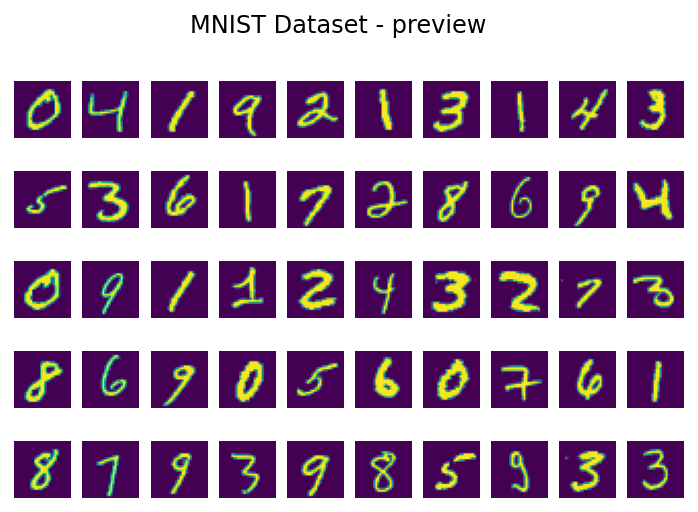

In [10]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview');

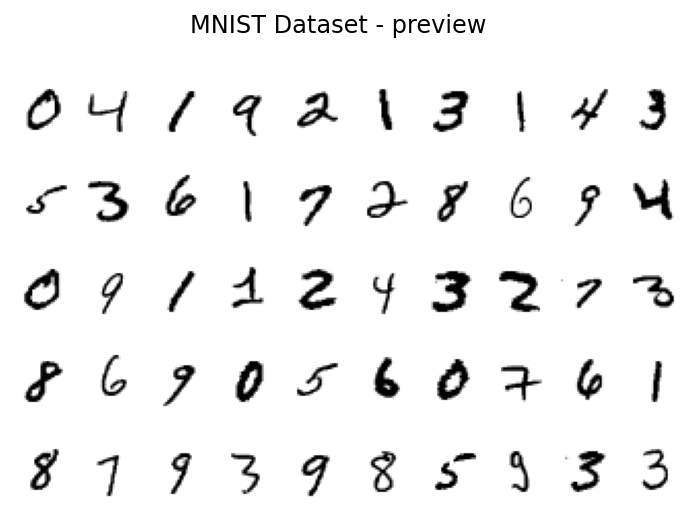

In [11]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

##Implementing LeNet-5

In [12]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [13]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

12:31:31 --- Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
12:32:14 --- Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
12:32:59 --- Epoch: 2	Train loss: 0.0550	Valid loss: 0.0542	Train accuracy: 98.59	Valid accuracy: 98.45
12:33:43 --- Epoch: 3	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.41
12:34:27 --- Epoch: 4	Train loss: 0.0343	Valid loss: 0.0416	Train accuracy: 99.24	Valid accuracy: 98.74
12:35:11 --- Epoch: 5	Train loss: 0.0298	Valid loss: 0.0416	Train accuracy: 99.40	Valid accuracy: 98.70
12:35:54 --- Epoch: 6	Train loss: 0.0242	Valid loss: 0.0421	Train accuracy: 99.51	Valid accuracy: 98.67
12:36:38 --- Epoch: 7	Train loss: 0.0226	Valid loss: 0.0453	Train accuracy: 99.48	Valid accuracy: 98.57
12:37:22 --- Epoch: 8	Train loss: 0.0186	Valid loss: 0.0461	Train accuracy: 99.51	Valid accuracy: 98.76
12:38:06 --- Epoch: 9	Train loss: 0.0167	Valid loss: 0.0484	Trai

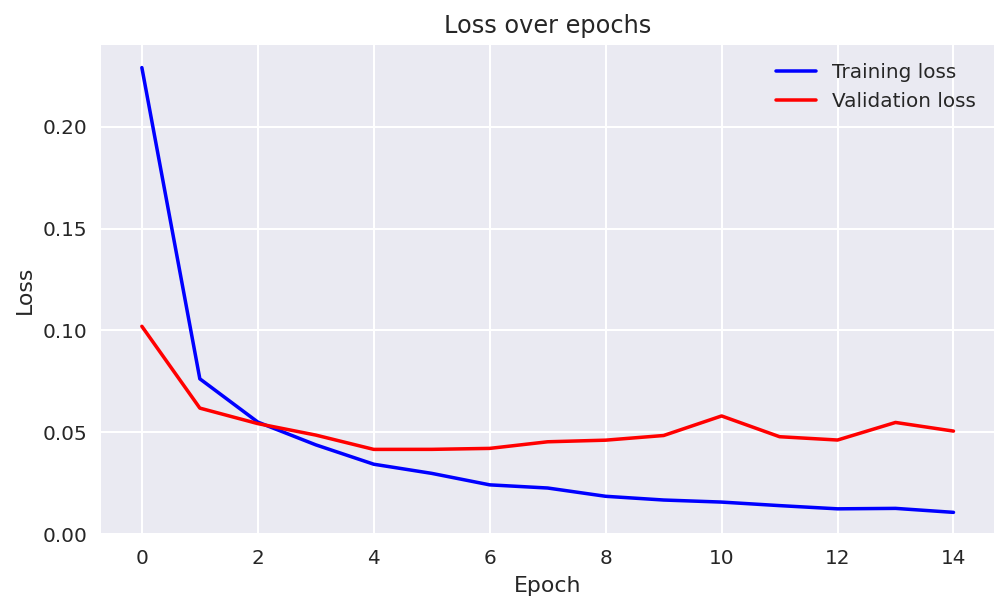

In [14]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

##Evaluating the predictions

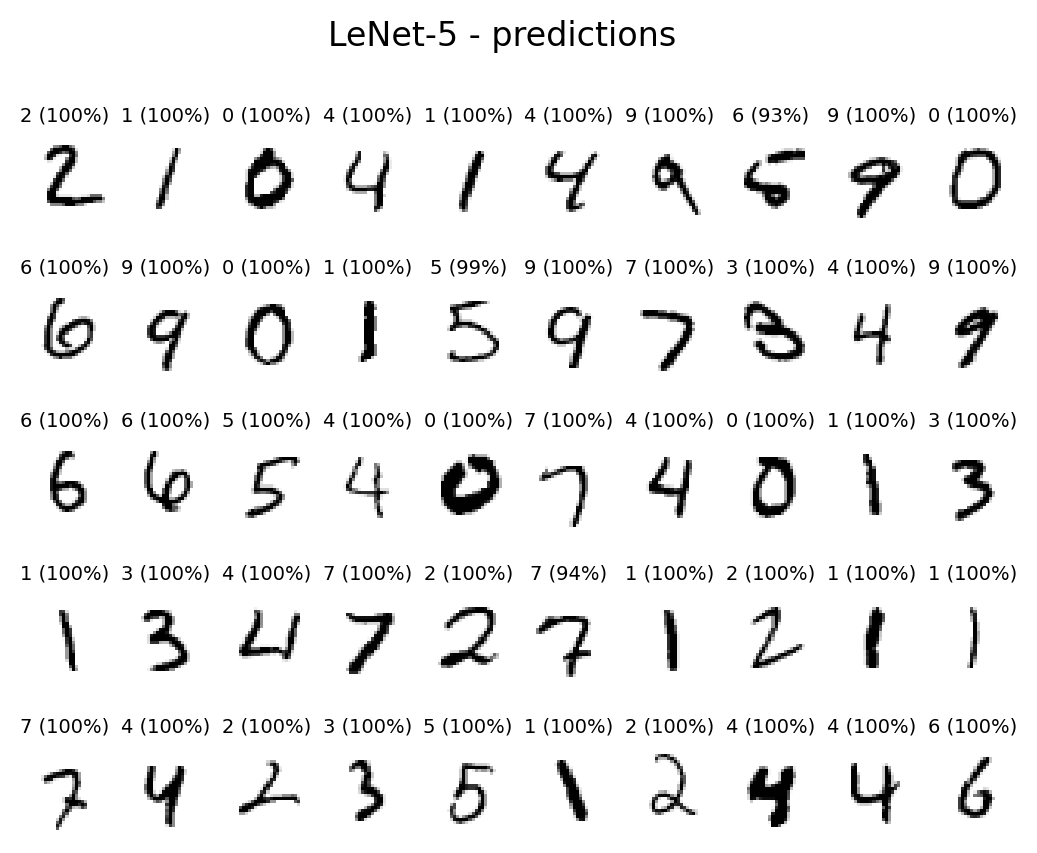

In [15]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');